# Stock Price Predictor

The stock market is a place where you can buy, sell, and trade stocks. A stock is a share of a company. So, buying a stock in a company is buying part of that company. If you buy a stock and the price of the company goes up, you will make money. If the price of that same company goes down, you will lose money. Being able to predict whether the price of a stock will rise or fall would be lucrative to any investor.

The Random Walk Hypothesis is a financial theory that states stock market prices are random, that the changes in price are unpredictable. The Random Walk Hypothesis is consistent with the Efficient Market Hypothesis (EMH). EMH is an investment theory that states that the price of a stock reflects all information made available to market participants at any given time. Based on Random Walk and EMH, it would be impossible for an investor to predict future prices.

I disagree with these theories. I believe an investor, armed with machine learning models, can predict the price of a stock better than the market can. Technical analysis or “identifying trading opportunities by analyzing statistical trends gathered from trading activity,” can help an investor predict future prices. Machine learning models can aid in technical analysis.

# DeepAR

I used DeepAR which is an Amazon SageMaker forecasting algorith. It uses a supervised learning algorithm for forecasting time series using recurrent neural networks. Detailed information about DeepAR can be found in the [AWS Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). DeepAR generates a single model over all of the time series.

# Financial Data

The data used in this notebook is about technology stocks. Data was taken from [Yahoo Finance](https://finance.yahoo.com/) using [rapidapi](https://rapidapi.com/apidojo/api/yahoo-finance1). Alternatively you could download CSV files for the data from Yahoo Finance.

# Load Resources

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
from requests import request
import json

import boto3
import sagemaker
from sagemaker import get_execution_role
import os
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.estimator import Estimator
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()

In [3]:
data_dir = 'json_stock_data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

In [4]:
prefix = 'deepar-stock-forecasting'

train_prefix = f'{prefix}/train'
test_prefix = f'{prefix}/test'

In [5]:
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

# Set Start and End Dates

You can change the timeframe you would like historical data for here.

In [6]:
start_date = '01/01/2009'
end_date = datetime.now()

start_timestamp = int(time.mktime(datetime.strptime(start_date, '%m/%d/%Y').timetuple()))
end_timestamp = int(datetime.timestamp(end_date))

# Load and Explore the Data

Use rapidapi to get historical data from Yahoo Finance. You are allowed 500 calls to Yahoo Finance a month using their freemium subscription. A credit card is required. Be sure to enter your information into the request headers.

You may also want to change the stocks you load data for. There are 20 stocks listed here which means there will be 20 api calls. DeepAR performs better with hundreds of related time series. For a better model, I would suggest using more stocks.

In [7]:
def load_historical_data(freq, start, end, symbol):
    url = 'https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-historical-data'
    
    query_string = {'frequency':freq,
                    'filter':'history',
                    'period1':start,
                    'period2':end,
                    'symbol':symbol
                   }
    
    headers = {'x-rapidapi-host': "YOUR RAPIDAPI-HOST", # ENTER INFO HERE
               'x-rapidapi-key': "YOUR RAPIDAPI-KEY" # ENTER INFO HERE
              }
    
    response = request('GET', url, headers=headers, params=query_string)
    
    return response

In [8]:
data = []
stock_tickers = ['AAPL', 'MSFT', 'INTC', 'CSCO', 'ADBE', 'CRM', 'NVDA', 'ACN', 'IBM', 'ORCL', 'TXN', 'QCOM', 'ADP', 'INTU', 'MU', 'AMD', 'ADSK', 'HPQ', 'AMZN', 'GOOG']
for ticker in stock_tickers:
    data.append(load_historical_data('1d', start_timestamp, end_timestamp, ticker))

# Format the Data

Each stock has 10 years of historical data. Each stock has its own time series (stock price and date). Data comes in in reverse chronological order which was then reversed.

In [9]:
price_data = [json.loads(d.text)['prices'] for d in data]

In [10]:
time_series = []
for stock in price_data:
    data = []
    index = []
    for day in stock:
        if 'adjclose' in day:
            data.append(day['adjclose'])
            index.append(datetime.fromtimestamp(day['date']))
    data.reverse()
    index.reverse()
    time_series.append(pd.Series(data=data, index=index))
    print(len(data))

2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802
2802


# Sanity Check

Take a look at the chart for the first stock.

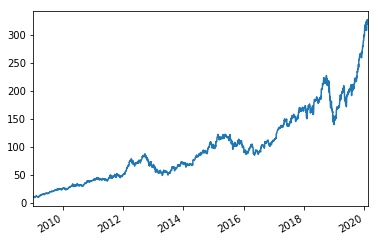

In [11]:
time_series[0].plot()
plt.show()

# Load VIX Data

The volatility index was used to help the DeepAR model. The VIX will be applied as a Dynamic Feature later.

In [12]:
vix_data = load_historical_data('1d', start_timestamp, end_timestamp, '^VIX')

In [13]:
vix_price_data = json.loads(vix_data.text)['prices']
v_data = []
v_index = []
for day in vix_price_data:
    if 'adjclose' in day:
        v_data.append(day['adjclose'])
        v_index.append(datetime.fromtimestamp(day['date']))
v_data.reverse()
v_index.reverse()
vix_time_series = pd.Series(data=v_data, index=v_index)

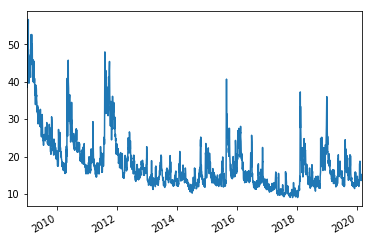

In [14]:
vix_time_series.plot()
plt.show()

# Split the Data

Create a training and test set

- Training Set: `time_series_training`
- Test Set: `time_series`

In [15]:
prediction_length = 30

time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

# Sanity Check

Take a look at the training vs test sets

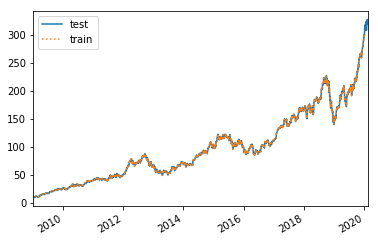

In [16]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=":")
plt.legend()
plt.show()

# Convert to JSON

According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html), DeepAR expects to see input training data in a JSON format.

In [17]:
def series_to_obj(ts, dynamic_feat):
    return {'start': str(ts.index[0]),
            'target': list(ts),
            'dynamic_feat': [list(dynamic_feat)]
           }

def series_to_jsonline(ts, dynamic_feat):
    return json.dumps(series_to_obj(ts, dynamic_feat))

def write_json_dataset(ts, filename, dynamic_feat, encoding='utf-8'):
    with open(filename, 'wb') as f:
        for t in ts:
            f.write(series_to_jsonline(t, dynamic_feat).encode(encoding))
            f.write('\n'.encode(encoding))
        print(filename, 'saved')

## Save the Data Locally

In [18]:
write_json_dataset(time_series_training, train_key, vix_time_series[:-prediction_length])
write_json_dataset(time_series, test_key, vix_time_series)

json_stock_data/train.json saved
json_stock_data/test.json saved


# Upload Data to S3

In [19]:
train_path = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path = sagemaker_session.upload_data(test_key, bucket=bucket, key_prefix=test_prefix)

# Train a DeepAR Estimator

In [42]:
s3_output_path = f's3://{bucket}/{prefix}/output'

estimator = Estimator(sagemaker_session=sagemaker_session,
             image_name=image_name,
             role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=s3_output_path
            )

# Set Hyperparameters

These hyperparameters were taken from a Hyperparameter tuning job from previous attempts at creating a DeepAR model. Information about DeepAR Hyperparameters can be found in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html).

In [43]:
hyperparameters = {
    'time_freq': 'D',
    'epochs': '30',
    'prediction_length': str(prediction_length),
    'context_length': str(prediction_length),
    'num_cells': '40',
    'num_layers': '4',
    'likelihood': 'gaussian',
    'learning_rate': '0.001',
    'early_stopping_patience': '10',
    'dropout_rate': '0.117'
}

In [44]:
estimator.set_hyperparameters(**hyperparameters)

# Training Job

DeepAR takes data from S3 for as input when training a model. We supply the data we saved to our S3 bucket earlier.

In [45]:
data_channels = {
    'train': train_path,
    'test': test_path
}

estimator.fit(inputs=data_channels)

2020-02-20 15:51:25 Starting - Starting the training job...
2020-02-20 15:51:26 Starting - Launching requested ML instances.........
2020-02-20 15:52:57 Starting - Preparing the instances for training......
2020-02-20 15:54:14 Downloading - Downloading input data...
2020-02-20 15:54:46 Training - Training image download completed. Training in progress.Arguments: train
[02/20/2020 15:54:49 INFO 140509456578368] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience

# Deploy and Create a Predictor

Our model needs a predictor endpoint to make predictions.

In [46]:
%%time

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    content_type='application/json'
)

-------------------------!CPU times: user 401 ms, sys: 9.21 ms, total: 411 ms
Wall time: 12min 32s


# Format Predictions

The predictor expects JSON input data. `json_predictor_input` helps format the time series to send to the predictor.

In [47]:
def json_predictor_input(input_ts, num_samples=30, quantiles=['0.1', '0.5', '0.9']):
    
    instances = []
    
    for k in range(len(input_ts)):
        instances.append(series_to_obj(input_ts[k], vix_time_series))
    
    configuration = {'num_samples': num_samples,
                     'output_types': ['quantiles'],
                     'quantiles': quantiles
                    }
    request_data = {'instances': instances,
                    'configuration': configuration
                   }
    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

# Analyse Predictions

Predictions do not come back in the best format to analyse. `decode_predictions` takes in a prediction and turns it into an easy to use DataFrame.

`display_quantiles` plots each prediction over the prediction length of 30 days.

In [48]:
def decode_prediction(prediction, encoding='utf-8'):
    prediction_data = json.loads(prediction.decode(encoding))
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [49]:
def display_quantiles(prediction_list, target_ts):
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        target = target_ts[k][-prediction_length:]
        plt.plot(range(len(target)), target, label='target')
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        prediction_list[k]['0.5'].plot(label='prediction media')
        plt.legend()
        plt.show()

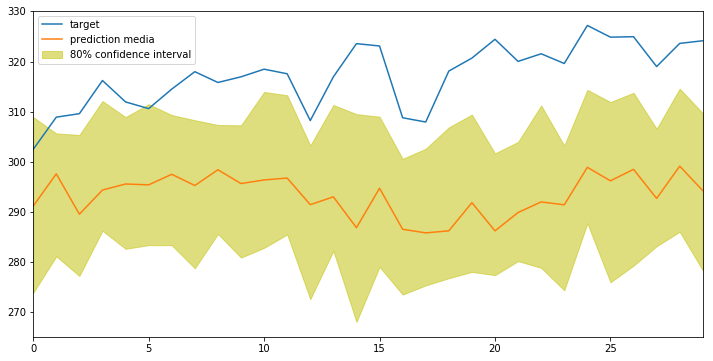

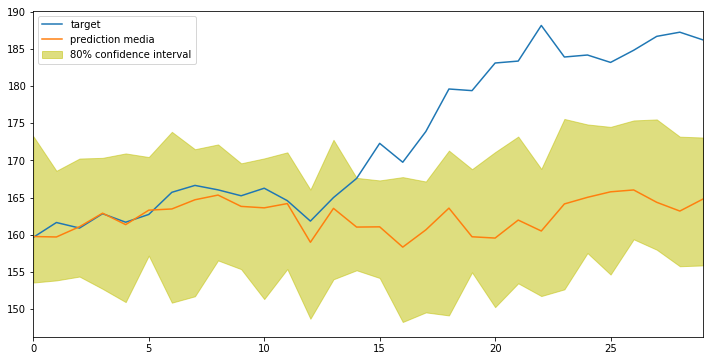

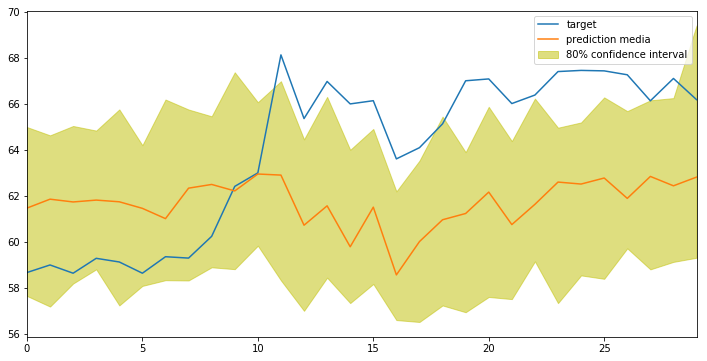

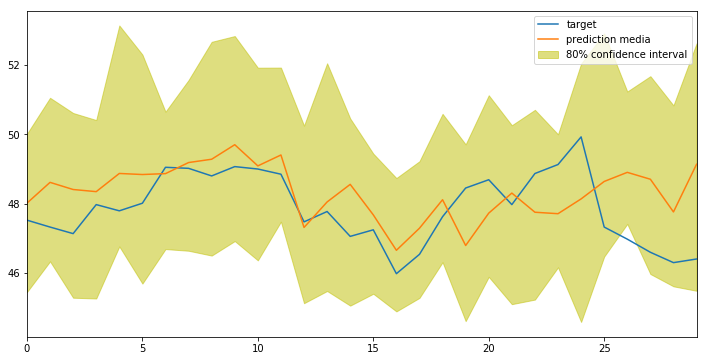

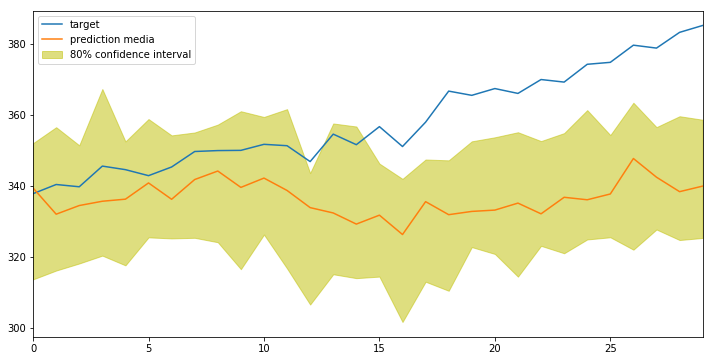

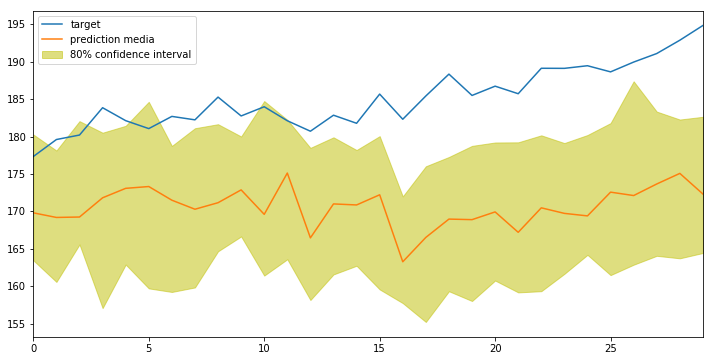

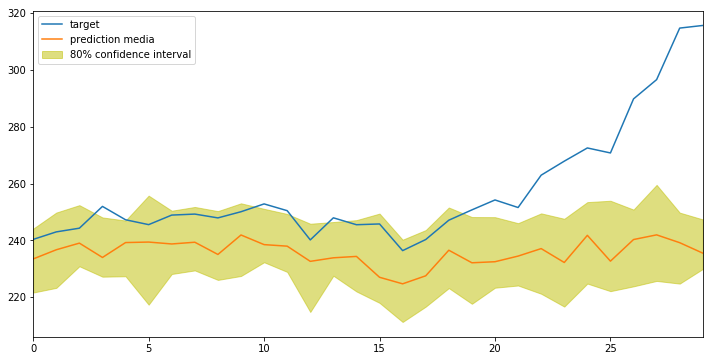

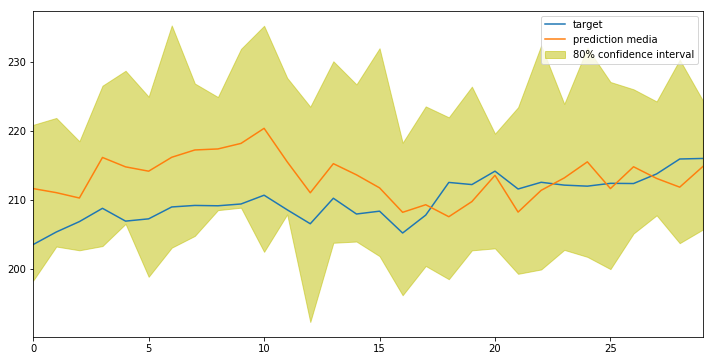

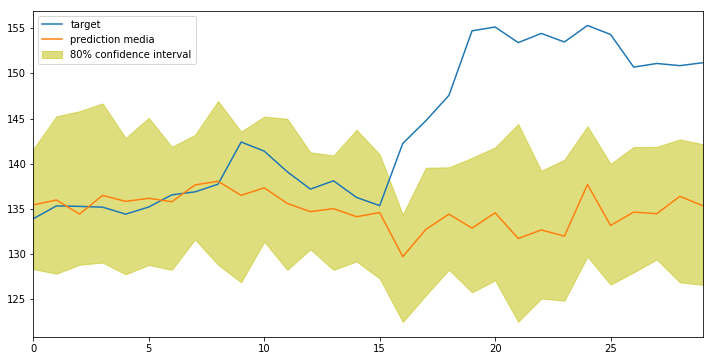

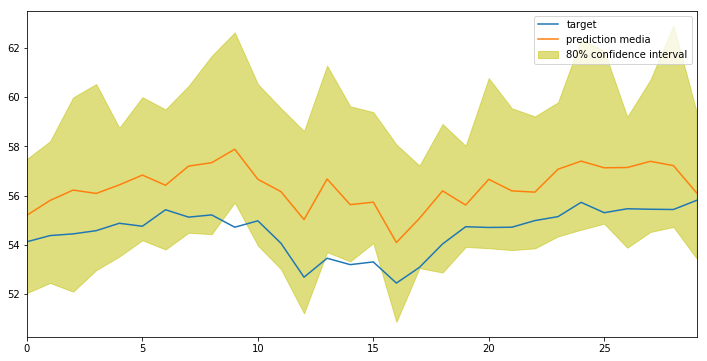

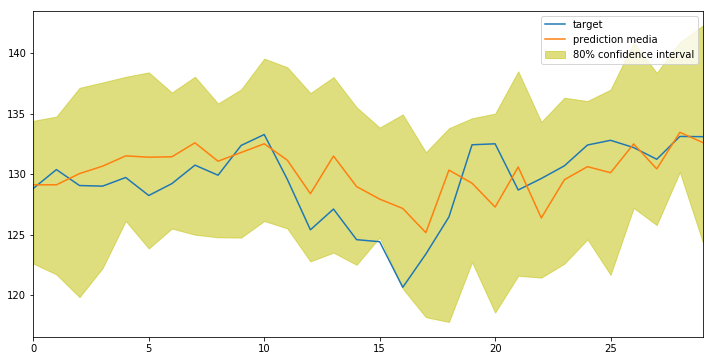

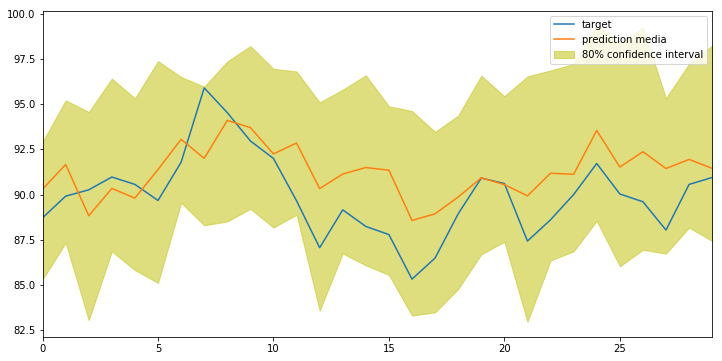

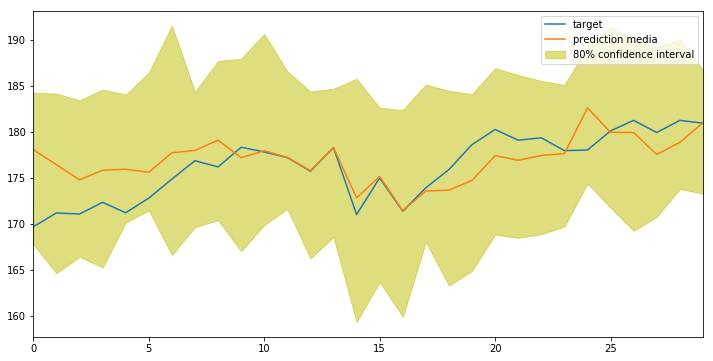

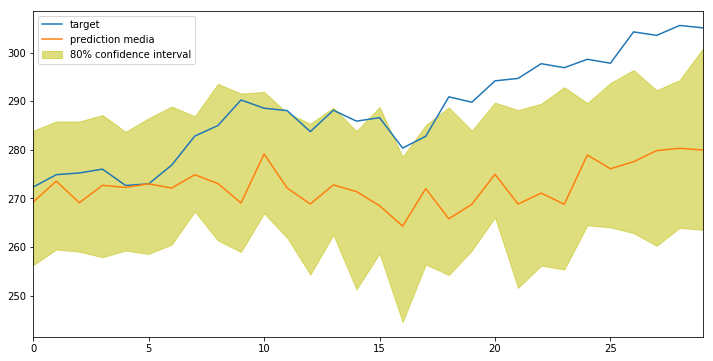

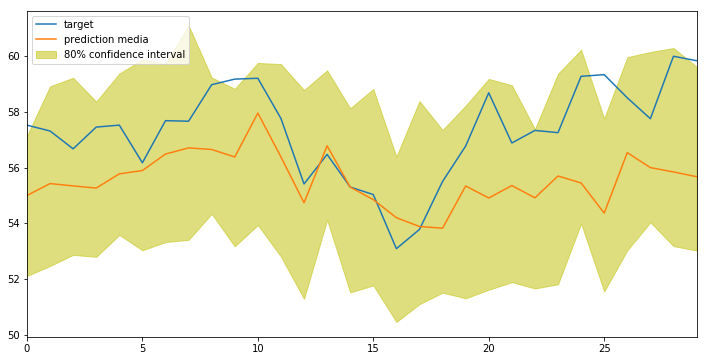

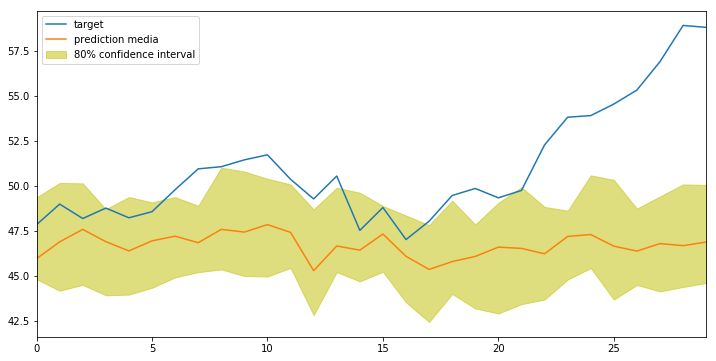

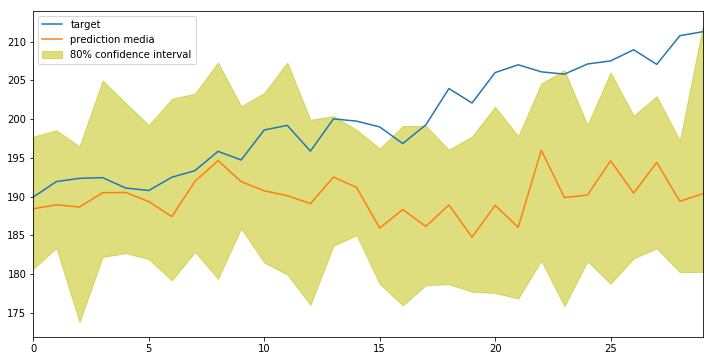

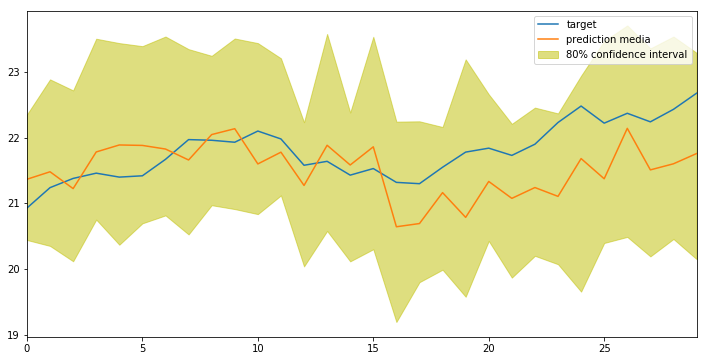

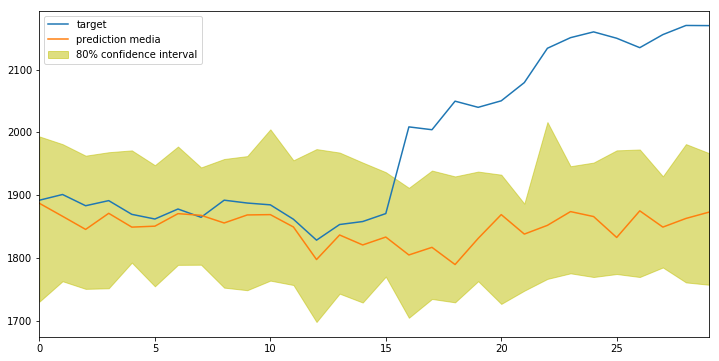

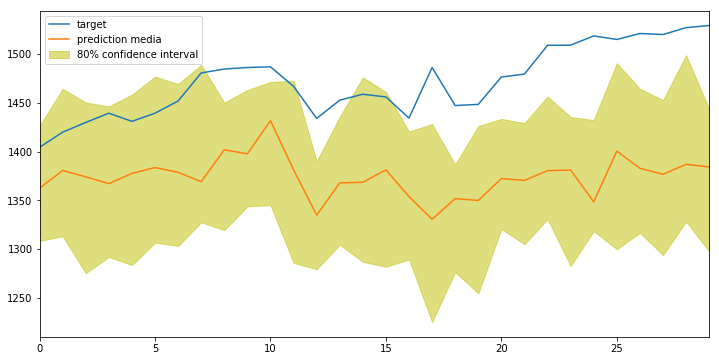

In [50]:
input_ts = time_series_training
target_ts = time_series

json_input_ts = json_predictor_input(input_ts)
json_prediction = predictor.predict(json_input_ts)

prediction_list = decode_prediction(json_prediction)
display_quantiles(prediction_list, target_ts)

## Mean Average Percentage Error

\begin{equation*}
M = \frac{1}{n} \sum_{t=1}^n |{\frac{A_t - F_t}{A_t}}|
\end{equation*}

MAPE is the method I used to gauge success.

In [51]:
def mape(df):
    model = np.array(df['model'])
    naive = np.array(df['naive'])
    actual = np.array(df['actual'])
    model_mape = np.mean(np.abs((actual - model) / actual)) * 100
    naive_mape = np.mean(np.abs((actual - naive) / actual)) * 100
    return model_mape, naive_mape

# Naive Method

MAPE of the model is being compared to the naive method of stock price forecasting. The Naive Method takes the last known price of the stock and forecasts that as the price going forward. We create a DataFrame for the Naive Method stock price prediction below.

In [52]:
results_list = prediction_list
for k in range(len(target_ts)):
    results_list[k] = results_list[k].drop(columns=['0.1', '0.9'])
    results_list[k] = results_list[k].rename(columns={'0.5':'model'})
    naive_pred = target_ts[k][-prediction_length-1:-prediction_length]
    results_list[k]['naive'] = [naive_pred[0] for _ in range(prediction_length)]
    results_list[k]['actual'] = list(target_ts[k][-prediction_length:])

# Compare Model to Naive Method

The model predictions, naive method predictions, and actual stock prices are plotted below.

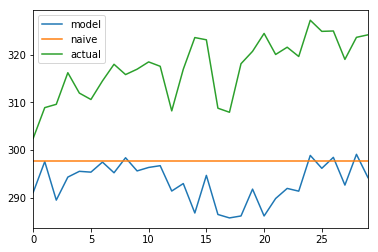

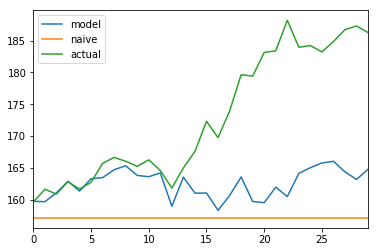

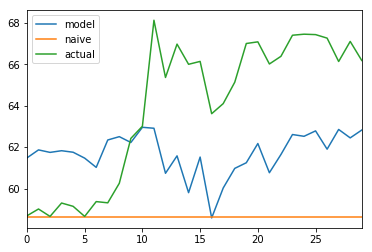

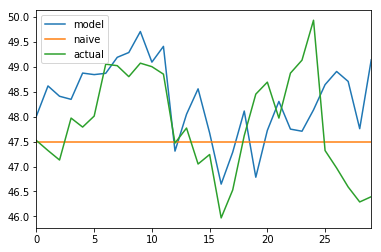

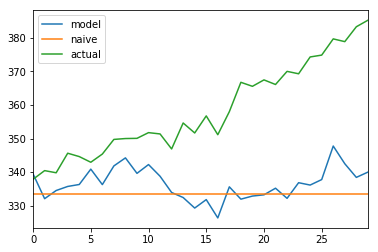

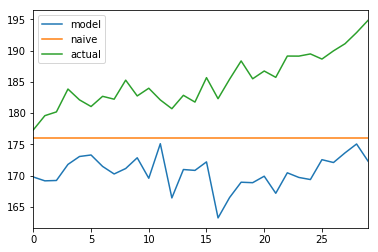

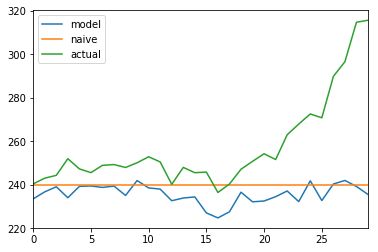

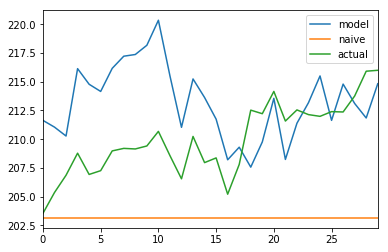

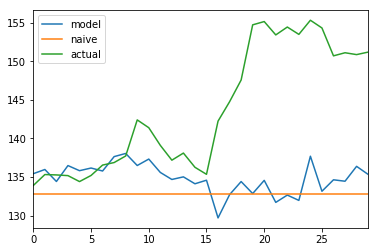

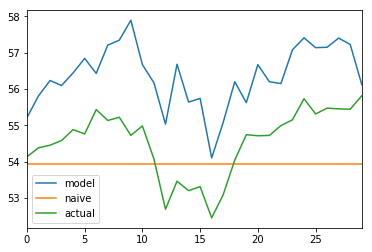

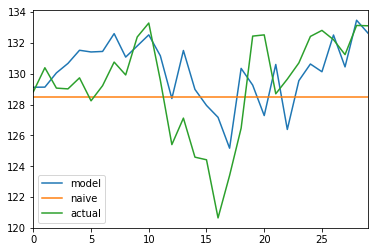

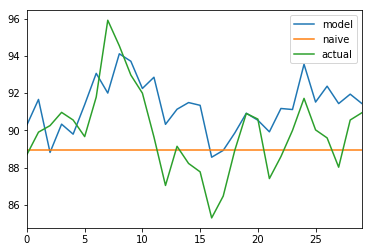

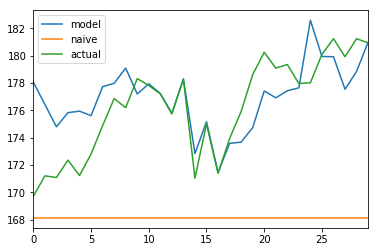

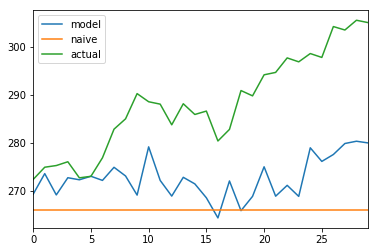

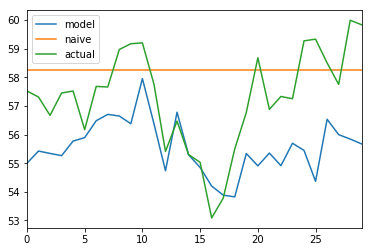

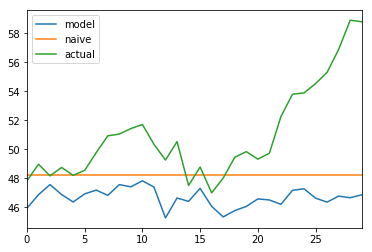

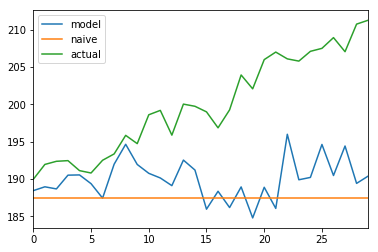

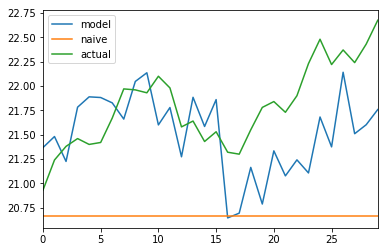

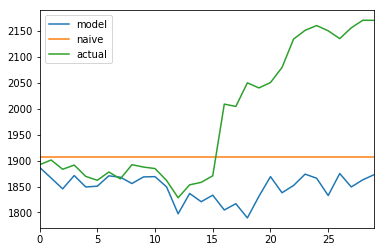

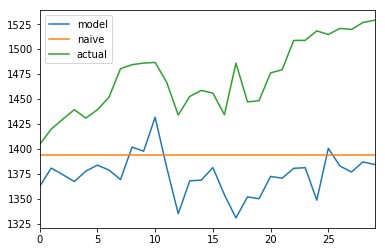

In [53]:
for k in range(len(results_list)):
    results_list[k].plot()

# Compare MAPE

Create a DataFrame for the MAPE of each stock. MAPE was calculated for 1-Day, 5-day, 10-day, 20 day, and 30-day forecasts. You can change the time frame when calling the `create_mape_df` function. The longest time period is 30 days which is the current prediction length.

In [54]:
def create_mape_df(df, time_frame=[1,5,10,20,30]):
    model_df = pd.DataFrame(index=stock_tickers)
    naive_df = pd.DataFrame(index=stock_tickers)
    for t in time_frame:
        model_mapes = []
        naive_mapes = []
        for k in range(len(results_list)):
            model, naive = mape(results_list[k][:t])
            model_mapes.append(model)
            naive_mapes.append(naive)
        model_df[f'{t}-day'] = model_mapes
        naive_df[f'{t}-day'] = naive_mapes
    return model_df, naive_df

# Model MAPE

In [55]:
model_df, naive_df = create_mape_df(results_list)
model_df

,1-day,5-day,10-day,20-day,30-day
AAPL,3.746179,5.210606,5.574112,6.790006,7.523672
MSFT,0.066539,0.325882,0.578516,2.747171,5.713363
INTC,4.769225,4.715008,4.034278,5.445572,5.922214
CSCO,1.035531,1.904977,1.425306,1.408990,2.005780
ADBE,0.472075,1.950953,1.986372,4.060844,5.982380
CRM,4.243842,5.526221,5.761175,6.837537,7.807695
NVDA,2.859052,3.592825,3.696909,4.526861,7.972062
ACN,3.976851,3.144211,3.444656,2.847282,2.191265
IBM,1.140401,0.852497,1.048413,3.111021,6.149748
ORCL,1.991578,2.699820,3.247742,3.575430,3.332647


# Naive MAPE

In [56]:
naive_df

,1-day,5-day,10-day,20-day,30-day
AAPL,1.583156,3.897945,4.719671,5.292743,6.133637
MSFT,1.567856,2.595607,3.753417,5.610161,8.773028
INTC,0.067835,0.531528,1.375553,5.933489,8.047588
CSCO,0.063129,0.562921,1.610361,1.584302,1.818353
ADBE,1.325948,2.418356,3.253070,4.715763,6.825946
CRM,0.750015,2.543084,3.128785,3.696259,4.874571
NVDA,0.187209,2.202002,2.797383,2.710498,6.369267
ACN,0.195766,1.519735,2.113438,2.454919,3.220082
IBM,0.827720,1.497187,2.530976,4.322330,7.276478
ORCL,0.387953,1.033144,1.543485,1.470943,1.798118


In [57]:
time_frame=[1, 5, 10, 20, 30]

compare_df = pd.DataFrame(index=stock_tickers)
for ticker in stock_tickers:
    for t in time_frame:
        compare_df[f'{t}-day'] = np.subtract(model_df[f'{t}-day'], naive_df[f'{t}-day'])

# Difference Between Model and Naive MAPE

In [58]:
compare_df

,1-day,5-day,10-day,20-day,30-day
AAPL,2.163023,1.312661,0.854441,1.497263,1.390035
MSFT,-1.501317,-2.269725,-3.174901,-2.862990,-3.059665
INTC,4.701390,4.183480,2.658724,-0.487917,-2.125374
CSCO,0.972403,1.342056,-0.185055,-0.175312,0.187428
ADBE,-0.853873,-0.467403,-1.266698,-0.654919,-0.843566
CRM,3.493826,2.983137,2.632389,3.141278,2.933124
NVDA,2.671843,1.390822,0.899525,1.816363,1.602795
ACN,3.781085,1.624476,1.331218,0.392363,-1.028817
IBM,0.312681,-0.644690,-1.482563,-1.211309,-1.126729
ORCL,1.603625,1.666676,1.704256,2.104487,1.534530


# Model Performance

The sum and the average of the compared MAPE DataFrame was taken to see how well the model did over time. As the time frame increased, the trained model did better than the Naive method. The Naive method was definitely better at predicting stock prices in the very short term (1-day) but the model outperformed the Naive method after that.

In [59]:
sum_df = compare_df.sum()
mean_df = compare_df.mean()

In [60]:
print("Sum of MAPE")
print('-'*20)
print(sum_df)
print("\nSum:", sum_df.sum())
print('-'*20)
print("Mean of MAPE")
print('-'*20)
print(mean_df)
print("\nMean", mean_df.mean())

Sum of MAPE
--------------------
1-day     29.724414
5-day     14.308785
10-day     0.024769
20-day    -1.046238
30-day    -5.316350
dtype: float64

Sum: 37.695379196895175
--------------------
Mean of MAPE
--------------------
1-day     1.486221
5-day     0.715439
10-day    0.001238
20-day   -0.052312
30-day   -0.265818
dtype: float64

Mean 0.3769537919689518
